In [1]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'
geometry = None
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

In [2]:
from quchem.Ansatz_Generator_Functions import *

ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)
ia_terms, ijab_terms, ia_theta, ijab_theta = ansatz_obj.Get_ia_and_ijab_terms()

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(ia_terms,
                                                                                                                    ijab_terms)

full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(ia_theta, ijab_theta)

# print(ansatz_cirq_circuit.to_text_diagram(transpose=True)) 

# Optimizer

In [3]:
from quchem.TensorFlow_Opt import *

In [4]:
from quchem.Simulating_Quantum_Circuit import *

In [16]:
n_shots=10000
def GIVE_ENERGY(theta_ia_theta_jab_list):
    theta_ia = theta_ia_theta_jab_list[:len(ia_theta)]
    theta_ijab = theta_ia_theta_jab_list[len(ijab_theta):]
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_ia, ijab_theta)

    VQE_exp = VQE_Experiment(QubitHamiltonian, ansatz_cirq_circuit, n_shots)
    

    return VQE_exp.Calc_Energy()

In [17]:
GIVE_ENERGY([0,0,0])

-1.064809831334113

https://arxiv.org/pdf/1906.08728.pdf

$$\frac{\partial O(\theta)}{\partial \theta}=\left\langle\overrightarrow{0}\left|\hat{U}^{\dagger} \hat{R}_{y}^{C \dagger}(\theta+\pi / 4) \hat{V}^{\dagger} \hat{O} \hat{V} \hat{R}_{y}^{C}(\theta+\pi / 4) \hat{U}\right| \overrightarrow{0}\right\rangle$
$-\left\langle\overrightarrow{0}\left|\hat{U}^{\dagger} \hat{R}_{y}^{C \dagger}(\theta-\pi / 4) \hat{V}^{\dagger} \hat{O} \hat{V} \hat{R}_{y}^{C}(\theta-\pi / 4) \hat{U}\right| \overrightarrow{0}\right\rangle$$

$$\frac{\partial O(\theta)}{\partial \theta} =O(\theta+\pi / 4)-O(\theta-\pi / 4)$$

In [12]:
def calc_gradient(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = GIVE_ENERGY(new_theta_list)
        
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = GIVE_ENERGY(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append((gradient, theta))
        

    return grad_list

In [8]:
calc_gradient([0,0,0])

[(-1.6218052015004476, 0), (-1.6133318169256432, 0), (-2.133201251288207, 0)]

starting input: [1, 2, 3] obj funct out: -0.4014129135674518
step 0 INPUT: [0.90000004, 2.1, 3.0999575] OUTPUT: -0.5248746249109983
step 1 INPUT: [0.8000901, 2.2000856, 3.1763797] OUTPUT: -0.6425402641153684
step 2 INPUT: [0.70054406, 2.2999623, 3.1938806] OUTPUT: -0.7637318028841905
step 3 INPUT: [0.60240203, 2.399536, 3.1907122] OUTPUT: -0.8548394034940119
step 4 INPUT: [0.5063722, 2.497981, 3.2289162] OUTPUT: -0.9147966591776825
step 5 INPUT: [0.41424268, 2.5949886, 3.2445316] OUTPUT: -0.9511457370022478
step 6 INPUT: [0.3289938, 2.6889133, 3.2573452] OUTPUT: -1.0199134617307737
step 7 INPUT: [0.2514207, 2.7790952, 3.2393723] OUTPUT: -1.0204689809179863
step 8 INPUT: [0.18082005, 2.8650193, 3.201864] OUTPUT: -1.0414039268849085
step 9 INPUT: [0.11881952, 2.9461255, 3.1727247] OUTPUT: -1.0659264875110774
step 10 INPUT: [0.064598724, 3.0231535, 3.143272] OUTPUT: -1.060334037590656
step 11 INPUT: [0.01594219, 3.0951612, 3.1155903] OUTPUT: -1.0668668499544744
step 12 INPUT: [-0.02740947

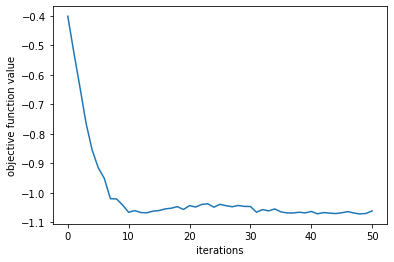

In [14]:
X0 = [1,2,3]

GG = Tensor_Flow_Optimizer(GIVE_ENERGY, X0, 'Adam', calc_gradient, learning_rate=0.1, beta1=0.9,
                            beta2=0.999, store_values=True, display_iter_steps=True)
GG.optimize(50)
GG.plot_convergence()

5.425764513301647

starting input: [3.5540698960792674, 3.625044814361125, 3.143509154137473] obj funct out: -0.7494834107272237
step 0 INPUT: [3.45407, 3.525045, 3.243498] OUTPUT: -0.8655383184991456
step 1 INPUT: [3.3545754, 3.425454, 3.331979] OUTPUT: -0.9557547262182786
step 2 INPUT: [3.2572565, 3.3273537, 3.3276253] OUTPUT: -1.0215176195307907
step 3 INPUT: [3.1643717, 3.233597, 3.3173583] OUTPUT: -1.0611429164035633
step 4 INPUT: [3.081152, 3.1482759, 3.296056] OUTPUT: -1.066294280409708
step 5 INPUT: [3.0126412, 3.0770645, 3.277439] OUTPUT: -1.049208813910159
step 6 INPUT: [2.9634037, 3.0241406, 3.2726765] OUTPUT: -1.0298147316050799
step 7 INPUT: [2.9344053, 2.9917479, 3.2895293] OUTPUT: -1.0076375674623474
step 8 INPUT: [2.9247823, 2.9787025, 3.2675612] OUTPUT: -0.9997477814616514
step 9 INPUT: [2.9311922, 2.9816298, 3.2824047] OUTPUT: -1.0052353324947758
step 10 INPUT: [2.949996, 2.99754, 3.2843578] OUTPUT: -1.0156598788242797
step 11 INPUT: [2.9787152, 3.0232363, 3.2985194] OUTPUT: -1.02869145

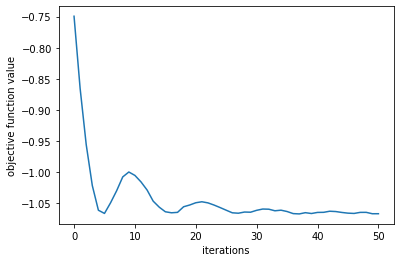

In [27]:
import random
X0 = [random.uniform(0, 2*np.pi) for _ in range(3)]
# X0 = [2.374, 1.437, 1.163]

GG = Tensor_Flow_Optimizer(GIVE_ENERGY, X0, 'Adam', calc_gradient, learning_rate=0.1, beta1=0.9,
                            beta2=0.999, store_values=True, display_iter_steps=True)
GG.optimize(50)
GG.plot_convergence()